In [1]:
# import all relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
import timeit
import pickle

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import datetime

%matplotlib inline

# Polynomial Regression with Ridge regularization (general functions)

First, we define general functions that iterate over degree, lamda and evaluate the regression. After that we use these functions on our trip and weather data to predict demand. 

## 1. Finding an appropriate Degree

In [22]:
#Firstly we want to iterate over the degree in order to find a good approximation of our data without overfitting
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

def iterating_over_degree(x, y, MAXdeg): 

    x_train, x_hold, y_train, y_hold = train_test_split(x, y, test_size=(0.2/0.7), random_state=34 ) #0.2/0.7 because we divided the set already in 70% train+holdout earlier

    err_train = []
    err_hold = []

    for deg in range(1, MAXdeg):
        # create poly features
        Poly = PolynomialFeatures(degree = deg)
        X_train_poly = Poly.fit_transform(x_train)
        X_hold_poly = Poly.fit_transform(x_hold)

        # fit model
        model_L2 = Ridge(alpha = 0, normalize = True, solver = 'lsqr') # select least squares regression as solver
        model_L2.fit(X_train_poly, y_train)

        # compute errors
        err_train.append(mean_squared_error(model_L2.predict(X_train_poly), y_train))
        err_hold.append(mean_squared_error(model_L2.predict(X_hold_poly), y_hold))

    plt.figure(figsize = (8,5))    
    plt.semilogy(range(1, MAXdeg), err_train, range(1, MAXdeg), err_hold)
    plt.legend(["Training", "Holdout"])
    plt.xlabel("Polynomial degree")
    plt.ylabel("Mean squared error")
    plt.show()

## 2. Finding an appropriate Lambda for the ridge regression

In [23]:
#After that we want to iterate over lambda/alpha in order to find a good regularization parameter
def iterating_over_lambda (x, y, deg, MINlambda, MAXlambda):


    err_train = []
    err_hold = []
    
    x_train, x_hold, y_train, y_hold = train_test_split(x, y, test_size=(0.2/0.7), random_state=34 ) #0.2/0.7 because we divided the set already in 70% train+holdout earlier

    for lam in np.logspace(MINlambda,MAXlambda,100):
        
        Poly = PolynomialFeatures(degree = deg)
        X_train_poly = Poly.fit_transform(x_train)
        X_hold_poly = Poly.fit_transform(x_hold)

        # fit model
        model_L2 = Ridge(alpha = lam, normalize = True, solver = 'lsqr') # select least squares regression as solver
        model_L2.fit(X_train_poly, y_train)

        # compute errors
        err_train.append(mean_squared_error(model_L2.predict(X_train_poly), y_train))
        err_hold.append(mean_squared_error(model_L2.predict(X_hold_poly), y_hold))

    plt.figure(figsize = (8,5))
    plt.loglog(np.logspace(MINlambda,MAXlambda,100), err_train, np.logspace(MINlambda,MAXlambda,100), err_hold)
    plt.legend(["Training", "Holdout"])
    plt.xlabel("$\lambda$ (or alpha in scikit learn terms)")
    plt.ylabel("Mean squared error")
    plt.show()

## 3. Evaluating the model

In [24]:
def evaluate_L2(x,y,deg, lam):
   
    Poly = PolynomialFeatures(degree = deg)
    X_poly = Poly.fit_transform(x)

    model_L2 = Ridge(alpha = lam, normalize = True, solver = 'lsqr') # select least squares regression as solver
    model_L2.fit(X_poly, y)
    
    print("Mean-Squared-Error: ", mean_squared_error(model_L2.predict(X_poly), y) )
    print("Mean-Absolute-Error: ", mean_absolute_error(model_L2.predict(X_poly), y) )
    print("R2 Score: ", r2_score(model_L2.predict(X_poly), y))

## Import our data

In [25]:
marburg = pd.read_pickle("../0_data/marburg_clean.pkl")
duisburg = pd.read_pickle('../0_data/duisburg_clean.pkl')
marburg_weather = pd.read_pickle("../0_data/weather/marburg_weather.pkl")
duisburg_weather = pd.read_pickle("../0_data/weather/duisburg_weather.pkl")
marburg_weather["h"]= marburg_weather.index
marburg_weather

,temperature,precipitation,h
timestamp,,,
2019-01-20 00:00:00,-7.9,0.0,2019-01-20 00:00:00
2019-01-20 01:00:00,-8.3,0.0,2019-01-20 01:00:00
2019-01-20 02:00:00,-8.7,0.0,2019-01-20 02:00:00
2019-01-20 03:00:00,-8.9,0.0,2019-01-20 03:00:00
2019-01-20 04:00:00,-8.7,0.0,2019-01-20 04:00:00
...,...,...,...
2020-01-20 19:00:00,-1.5,0.0,2020-01-20 19:00:00
2020-01-20 20:00:00,-1.7,0.0,2020-01-20 20:00:00
2020-01-20 21:00:00,-2.3,0.0,2020-01-20 21:00:00


# Marburg

In [26]:
ma = pd.DataFrame(marburg.resample('H').count()["day"])
ma.rename(columns={'day': 'demand'}, inplace=True)

ma['dayofyear'] = ma.index.map(lambda datetime : datetime.dayofyear)
ma['week'] = ma.index.map(lambda datetime : datetime.week)
ma['weekday'] = ma.index.map(lambda datetime : datetime.weekday)
ma['is_weekday'] = ma['weekday'].map(lambda day : day < 5)
ma['hour'] = ma.index.map(lambda datetime : datetime.hour)

ma = ma.merge(marburg_weather, left_index=True, right_index=True) #Merging weather and bike date

## 1. Finding Degree

In [71]:
X_ma = ma[['temperature', 'hour', 'precipitation', 'dayofyear']]
y_ma = ma['demand']

X_train_ma, X_test_ma, y_train_ma, y_test_ma = train_test_split(X_ma, y_ma, test_size=0.3,random_state=34 )

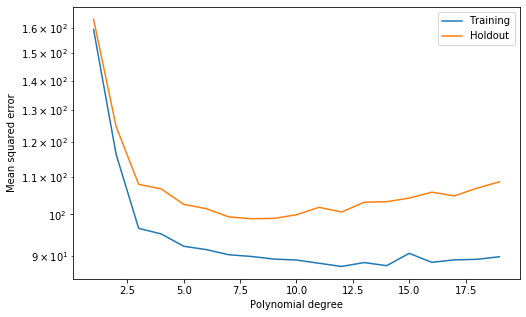

In [72]:
iterating_over_degree(X_train_ma,y_train_ma,20)

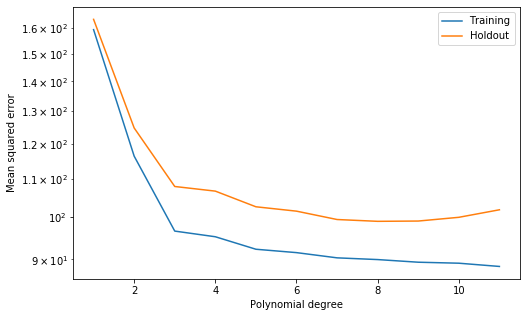

In [73]:
iterating_over_degree(X_train_ma,y_train_ma,12)

We see that there is only a significant improvement in the MSE up to a degree of 4 (or 7?) --> or 10??

## 2. Finding lambda

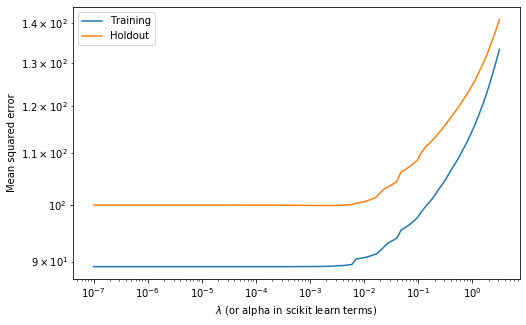

In [74]:
iterating_over_lambda(X_train_ma.values,y_train_ma.values,10,-7, 0.5)

We choose a lamda of 0.001

## 3. Evaluating Model

In [88]:
evaluate_L2(X_test_ma,y_test_ma,10,0.001)

Mean-Squared-Error:  96.71538913638152
Mean-Absolute-Error:  7.332898963457918
R2 Score:  0.41508748341905966


# Duisburg

In [13]:
du = pd.DataFrame(duisburg.resample('H').count()["day"])
du.rename(columns={'day': 'demand'}, inplace=True)

du['dayofyear'] = du.index.map(lambda datetime : datetime.dayofyear)
du['week'] = du.index.map(lambda datetime : datetime.week)
du['weekday'] = du.index.map(lambda datetime : datetime.weekday)
du['is_weekday'] = du['weekday'].map(lambda day : day < 5)
du['hour'] = du.index.map(lambda datetime : datetime.hour)

du = du.merge(duisburg_weather, left_index=True, right_index=True)

## Finding Degree

In [32]:
X_du = du[['temperature', 'hour', 'precipitation', 'dayofyear']]
y_du = du['demand']

X_train_du, X_test_du, y_train_du, y_test_du = train_test_split(X_du, y_du, test_size=0.3,random_state=34 )

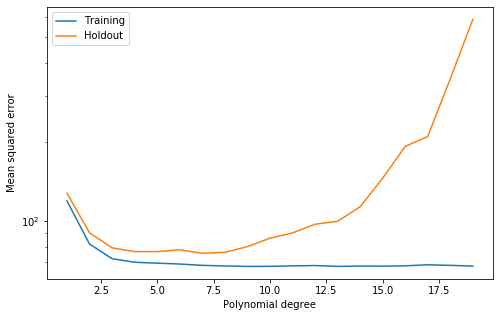

In [33]:
iterating_over_degree(X_train_du,y_train_du,20)

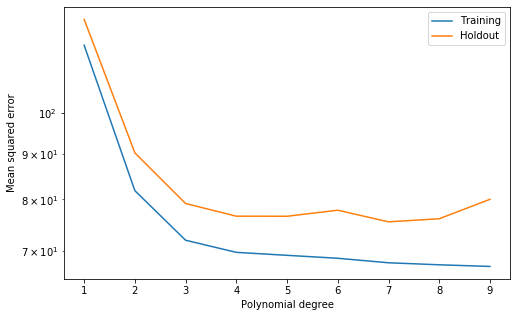

In [96]:
#Let's zoom in a little bit
iterating_over_degree(X_train_du,y_train_du,10)

The Graph shows that there is only a significant improvement in the mean squared error up to a degree of 4 --> or 8??

## Find Lamda

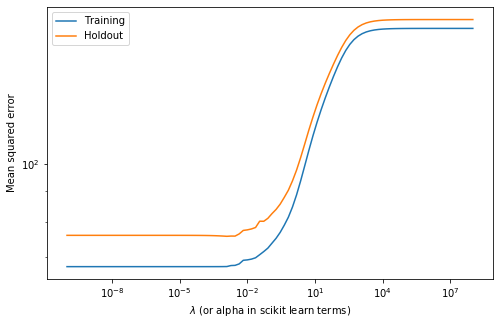

In [97]:
iterating_over_lambda(X_train_du.values,y_train_du.values,8,-10, 8)

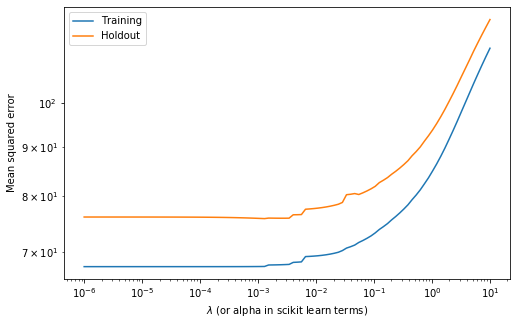

In [98]:
#Zooming in
iterating_over_lambda(X_train_du.values,y_train_du.values,8,-6, 1)

We choose a Lambda of 0.0001

## 3. Evaluating Model

In [106]:
evaluate_L2(X_test_du,y_test_du,8,0.0001)

Mean-Squared-Error:  69.56701573292311
Mean-Absolute-Error:  6.290838866852882
R2 Score:  0.3412147291944392
